# Face Detection and Recognition CNN Models

In [88]:
import numpy as np
import torch
from torch import nn
import scipy.io
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import torch.jit
import matplotlib.pyplot as plt
from matplotlib import ticker

# mirar diferencias entre estos dos y elegir uno
from torch.utils.data import random_split
from torchvision.transforms.functional import get_image_size

In [89]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [90]:
# Hyperparameters
lr = 0.001
epoch_step = 5
epochs = 20
batch_size = 32 # o 16
images_path = './TRAINING/'
target_matrix_path = ''
resized = (224, 224)

## Loading the dataset

In [134]:
class MyData(Dataset):
    # the data is in the form [img_name, boundaries] or [img_name, identity]
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, label = self.data[idx]
        with Image.open(images_path + image_name) as image:
            # Apply transformations if specified
            image = image.convert('RGB')
            w, h = get_image_size(image)
            if self.transform:
                image = self.transform(image)
            # image = torch.tensor(image, dtype=torch.float32)

            label = [label[0]/w*resized[0], label[1]/h*resized[1], label[2]/w*resized[0], label[3]/h*resized[1]]
            label = torch.tensor(label, dtype=torch.float32)
            label = torch.flatten(label)
            return image, label

In [135]:
def load_data(labels_path, labels_wanted='boundaries'):
    mat = scipy.io.loadmat(labels_path)['AGC_Challenge3_TRAINING'][0]
    data = []
    for entry in mat:
        key = entry[1][0]
        if (labels_wanted == 'boundaries'):
            # label = np.array([0, 0, 0, 0], dtype=np.int32)
            if (len(entry[2]) > 0):
                label = np.array(entry[2][0], dtype=np.int32)
                data.append([key, label])
        elif (labels_wanted == 'identity'):
            data.append([key, entry[0][0][0]])
    return data

In [136]:
# mean and std extracted from the train_dataset part of AGC_Challenge3_TRAINING
def compute_mean_std(dataset):
    all_pixels = []
    for image_path, _ in dataset:
        with Image.open(images_path + image_path) as image:
            image_array = np.array(image)
            all_pixels.append(image_array)

    all_images = np.stack(all_pixels, axis=0)

    mean = np.mean(all_images, axis=(0, 1, 2)) / 255.0
    std_dev = np.std(all_images, axis=(0, 1, 2)) / 255.0

    return mean, std_dev

In [137]:
# transforms son copiados, revisar
# calcular valores de mean y std del dataset para cada channel
# o las de imagenet
# flipping, cambios de colores, grayscale
# contraste de saturacion 
# color spaces
################

all_data = load_data(target_matrix_path + 'AGC_Challenge3_Training.mat')
train_data, val_data, test_data = random_split(all_data, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(42))

# train_mean, train_std = compute_mean_std(train_data)

transform = transforms.Compose([
    # transforms.Resize(300, 300),
    transforms.RandomResizedCrop(resized),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(20),
    transforms.ToTensor(),
    # transforms.Normalize(mean=train_mean, std=train_std)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_base = transforms.Compose([
    transforms.Resize(resized),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = MyData(train_data, transform)
val_dataset = MyData(val_data, transform)
test_dataset = MyData(test_data, transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## The detection model

In [138]:
class DetectionCNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(25088, 16), # 128*8*8 or 128*3*4
            nn.ReLU(inplace=True),
            nn.Linear(16, 4)
        )

    def forward(self, data):
        x = self.cnn_layers(data)
        x = self.flatten(x) # before linear layer !!!
        x = self.fc_layers(x)
        return x

    def fit(self, training_data, loss_fn, optimizer: optim.Optimizer): # cross entropy con softmax + adam
        self.train()
        total_loss = 0.0

        for batch_data, target in training_data:
            batch_data = batch_data.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            output = self.forward(batch_data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        return total_loss / len(training_data)

        # for e in range(epochs):
        #     epoch_loss = 0

        #     if e % epoch_step == 0:
        #         print(f'Epoch {e} has loss {epoch_loss / batch_size}')

    def evaluate(self, validation_data, loss_fn): # unused by now
        self.eval()
        total_loss = 0.0

        for batch_data, target in validation_data:
            batch_data = batch_data.to(device)
            target = target.to(device)
            
            output = self.forward(batch_data)
            loss = loss_fn(output, target)

            total_loss += loss.item()

            # Compute accuracy
            # _, predicted = torch.max(output, 1)
            # total_predictions += labels.size(0)
            # correct_predictions += (predicted == labels).sum().item()

        # average_loss = total_loss / len(validation_data)
        # accuracy = correct_predictions / total_predictions

        return total_loss / len(validation_data)

    def predict(self, test_image):
        self.eval()
        with torch.inference_mode(mode=True):
            test_image = test_image.convert('RGB')
            w, h = get_image_size(test_image)
            test_image = transform_base(test_image)
            test_image = torch.tensor(test_image, dtype=torch.float32)
            output = self.forward(test_image.unsqueeze(0))[0]
            print(output)
            output = [output[0]*w/resized[0], output[1]*h/resized[1], output[2]*w/resized[0], output[3]*h/resized[1]]
            print(output)
            return output

In [139]:
detection = DetectionCNNModel().to(device)
print(detection)

DetectionCNNModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cnn_layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=25088, out_features=16

In [140]:
pytorch_total_params = sum(p.numel() for p in detection.parameters())
print(pytorch_total_params)

407636


## Training loop

In [142]:
# train loop as train and then test
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(detection.parameters(), lr=lr)

tr_losses = []
val_losses = []
for epoch in range(epochs):
    epoch_loss = 0
    tr_losses.append(detection.fit(train_loader, loss, optimizer))
    val_losses.append(detection.evaluate(val_loader, loss))

    if epoch % epoch_step == 0:
        print(f'Epoch {epoch} has loss {val_losses[epoch]}')

Epoch 0 has loss 483.6799621582031
Epoch 5 has loss 479.493896484375
Epoch 10 has loss 477.41383361816406
Epoch 15 has loss 476.51007080078125


In [143]:
def loss_epoch_plot(losses, title='Loss vs training epochs', nbins='auto'):
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=nbins, integer=True))
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    x = np.linspace(1, len(losses)+1, len(losses), dtype=np.uint16)
    plt.plot(x, losses)
    
    plt.show()

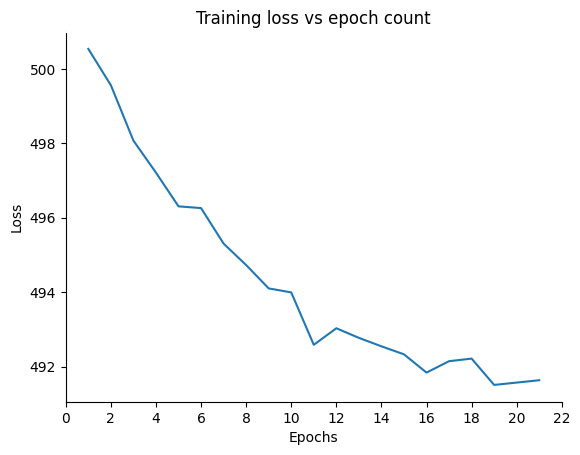

In [144]:
loss_epoch_plot(tr_losses, "Training loss vs epoch count", epochs)

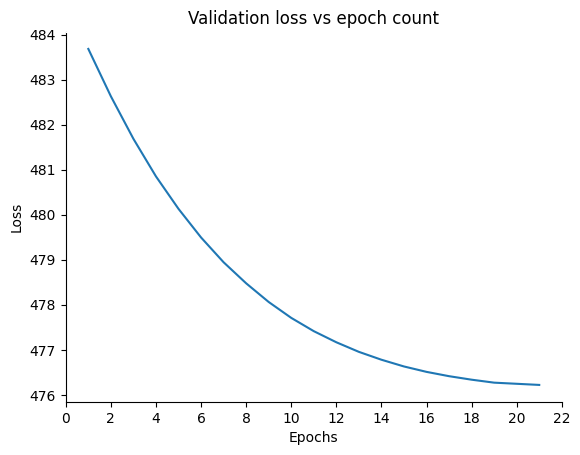

In [145]:
loss_epoch_plot(val_losses, "Validation loss vs epoch count", epochs)

In [146]:
detection_scripted = torch.jit.script(detection)
detection_scripted.save('detection_model.pt')

In [147]:
with Image.open(images_path + 'image_A0003.jpg') as image:
    detection.predict(image)

tensor([-0.2041, -0.6967,  0.5613,  0.3098])
[tensor(-0.5687), tensor(-1.0295), tensor(1.5636), tensor(0.4577)]


/tmp/ipykernel_5293/1232605328.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_image = torch.tensor(test_image, dtype=torch.float32)


## The recognition model

In [ ]:
# class RecognitionCNNModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.flatten = nn.Flatten()

# 2 linear layers
# va a sacar un vector y hacer argmax
# multimodal ??

In [ ]:
# model = RecognitionCNNModel().to(device)
# print(model)

In [ ]:
# torch.save(model, 'recognition_model.pth') # not model.state_dict() because we want to store the class also